In [1]:
!pip install seqeval

In [54]:
import os
import re
import numpy as np
from tqdm import tqdm
import json
import copy

import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

import pandas as pd
import matplotlib.pyplot as plt

In [55]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string])
    plt.show()

In [56]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
MAX_LEN = 111 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [57]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", "train.tsv")
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", "label.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", "test.tsv")

def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, "r", encoding="utf-8") as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split("\t")
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels

train_sentences, train_labels = read_file(DATA_TRAIN_PATH)

train_ner_dict = {"sentence": train_sentences, "label": train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)

test_sentences, test_labels = read_file(DATA_TEST_PATH)
test_ner_dict = {"sentence": test_sentences, "label": test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

print("개체명 인식 학습 데이터 개수: {}".format(len(train_ner_df)))
print("개체명 인식 테스트 데이터 개수: {}".format(len(test_ner_df)))

# 개체명 인식 학습 데이터 개수: 81000
# 개체명 인식 테스트 데이터 개수: 9000

개체명 인식 학습 데이터 개수: 81000
개체명 인식 테스트 데이터 개수: 9000


In [58]:
# Label 불러오기

def get_labels(label_path):
    return [label.strip() for label in open(os.path.join(label_path), 'r', encoding='utf-8')]

ner_labels = get_labels(DATA_LABEL_PATH)

print("개체명 인식 레이블 개수: {}".format(len(ner_labels)))

개체명 인식 레이블 개수: 30


In [8]:
# 버트 토크나이저 설정

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt')

pad_token_id = tokenizer.pad_token_id # 0
pad_token_label_id = 0
cls_token_label_id = 0
sep_token_label_id = 0

loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt from cache at bert_ckpt\eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer_config.json from cache at bert_ckpt\f55e7a2ad4f8d0fff2733b3f79777e1e99247f2e4583703e92ce74453af8c235.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at bert_ckpt\6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
Model conf

In [9]:
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        truncation=True,
        add_special_tokens = True, #'[CLS]'와 '[SEP]' 추가
        max_length = MAX_LEN,           # 문장 패딩 및 자르기 진행
        pad_to_max_length = True,
        return_attention_mask = True   # 어탠션 마스크 생성
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] 
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

def convert_label(words, labels_idx, ner_begin_label, max_seq_len):
            
    tokens = []
    label_ids = []

    for word, slot_label in zip(words, labels_idx):

        word_tokens = tokenizer.tokenize(word)
        if not word_tokens:
            word_tokens = [unk_token]
        tokens.extend(word_tokens)
        
        # 슬롯 레이블 값이 Begin이면 I로 추가
        if int(slot_label) in ner_begin_label:
            label_ids.extend([int(slot_label)] + [int(slot_label) + 1] * (len(word_tokens) - 1))
        else:
            label_ids.extend([int(slot_label)] * len(word_tokens))
  
    # [CLS] and [SEP] 설정
    special_tokens_count = 2
    if len(label_ids) > max_seq_len - special_tokens_count:
        label_ids = label_ids[: (max_seq_len - special_tokens_count)]

    # [SEP] 토큰 추가
    label_ids += [sep_token_label_id]

    # [CLS] 토큰 추가
    label_ids = [cls_token_label_id] + label_ids
    
    padding_length = max_seq_len - len(label_ids)
    label_ids = label_ids + ([pad_token_label_id] * padding_length)
    
    return label_ids

In [10]:
# 테스트용
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]
ner_begin_label_string = [ner_labels[label_index] for label_index in ner_begin_label]

print(ner_begin_label)
print(ner_begin_label_string)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
['PER-B', 'FLD-B', 'AFW-B', 'ORG-B', 'LOC-B', 'CVL-B', 'DAT-B', 'TIM-B', 'NUM-B', 'EVT-B', 'ANM-B', 'PLT-B', 'MAT-B', 'TRM-B']


In [39]:
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if "B" in begin_label]

def create_inputs_targets(df):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    label_list = []

    for i, data in enumerate(df[['sentence', 'label']].values):
        sentence, labels = data
        words = sentence.split()
        labels = labels.split()
        labels_idx = []
#         print(sentence)
#         print(words)
        
        for label in labels:
            labels_idx.append(ner_labels.index(label) if label in ner_labels else ner_labels.index("UNK"))

#         print(labels_idx)    
        
        assert len(words) == len(labels_idx)

        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)

        convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)

#         print(input_id)
#         print(convert_label_id)
#         break
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label_list.append(convert_label_id)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    label_list = np.asarray(label_list, dtype=int) #레이블 토크나이징 리스트
    inputs = (input_ids, attention_masks, token_type_ids)
    
    return inputs, label_list

train_inputs, train_labels = create_inputs_targets(train_ner_df)
test_inputs, test_labels = create_inputs_targets(test_ner_df)

In [12]:
class TFBertNERClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertNERClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                name="ner_classifier")

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):

        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[0]
                
        sequence_output = self.dropout(sequence_output, training=training)
        logits = self.classifier(sequence_output)
        

        return logits

In [13]:
ner_model = TFBertNERClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=len(ner_labels))

loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at bert_ckpt\6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cach

In [15]:
def compute_loss(labels, logits):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.NONE
    )

    # 0의 레이블 값은 손실 값을 계산할 때 제외
    active_loss = tf.reshape(labels, (-1,)) != 0
        
    reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, logits.get_shape().as_list()[2])), active_loss)
        
    labels = tf.boolean_mask(tf.reshape(labels, (-1,)), active_loss)
    
    return loss_fn(labels, reduced_logits)

In [16]:
class F1Metrics(tf.keras.callbacks.Callback):
    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def compute_f1_pre_rec(self, labels, preds):

        return {
            "precision": precision_score(labels, preds, suffix=True),
            "recall": recall_score(labels, preds, suffix=True),
            "f1": f1_score(labels, preds, suffix=True)
        }


    def show_report(self, labels, preds):
        return classification_report(labels, preds, suffix=True)
        
    def on_epoch_end(self, epoch, logs=None):

        results = {}
        
        pred = self.model.predict(self.x_eval)
        label = self.y_eval
        pred_argmax = np.argmax(pred, axis = 2)

        slot_label_map = {i: label for i, label in enumerate(ner_labels)}

        out_label_list = [[] for _ in range(label.shape[0])]
        preds_list = [[] for _ in range(label.shape[0])]

        for i in range(label.shape[0]):
            for j in range(label.shape[1]):
                if label[i, j] != 0:
                    out_label_list[i].append(slot_label_map[label[i][j]])
                    preds_list[i].append(slot_label_map[pred_argmax[i][j]])
                    
        result = self.compute_f1_pre_rec(out_label_list, preds_list)
        results.update(result)

        print("********")
        print("F1 Score")
        for key in sorted(results.keys()):
            print("{}, {:.4f}".format(key, results[key]))
        print("\n" + self.show_report(out_label_list, preds_list))
        print("********")

f1_score_callback = F1Metrics(test_inputs, test_labels)

In [17]:
# Prepare training: Compile tf.keras model with optimizer, loss and learning rate schedule
optimizer = tf.keras.optimizers.Adam(3e-5)
# ner_model.compile(optimizer=optimizer, loss=compute_loss, run_eagerly=True)
ner_model.compile(optimizer=optimizer, loss=compute_loss)

In [18]:
model_name = "tf2_bert_ner"

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)

history = ner_model.fit(train_inputs, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                        callbacks=[cp_callback, f1_score_callback])

print(history.history)

data_out/KOR\tf2_bert_ner -- Folder already exists 

Epoch 1/3
2532/2532 [==============================] - ETA: 0s - loss: 0.4282WARNING:tensorflow:Can save best model only with val_loss available, skipping.
********
F1 Score
f1, 0.7430
precision, 0.7071
recall, 0.7827

              precision    recall  f1-score   support

         AFW       0.37      0.45      0.40       393
         ANM       0.53      0.71      0.61       699
         CVL       0.64      0.73      0.68      5735
         DAT       0.80      0.90      0.85      2510
         EVT       0.62      0.72      0.67      1093
         FLD       0.40      0.40      0.40       228
         LOC       0.66      0.78      0.72      2124
         MAT       0.17      0.08      0.11        12
         NUM       0.86      0.88      0.87      5544
         ORG       0.72      0.77      0.74      4055
         PER       0.76      0.82      0.79      4412
         PLT       0.42      0.15      0.22        34
         TIM       0.76  

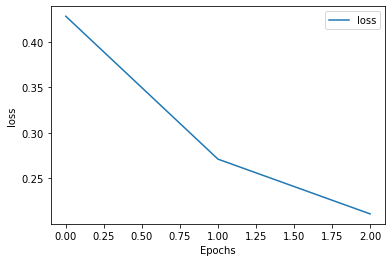

In [19]:
plot_graphs(history, 'loss')

In [20]:
ner_model.save_weights('weights_NER.h5')

In [37]:
ner_model.load_weights('weights_NER.h5')

In [45]:
print(test_inputs[0][0])
print(test_inputs[1][0])
print(test_inputs[2][0])

[   101   8982  16985  11287   9954   9477  15184  11261  20308  11513
  23969   9672  11102 100699  10530  18154   9706 119285  12092  11506
    119    102      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [43]:
test_labels[0]

array([ 0,  1,  1,  1, 18, 19, 19, 19, 19, 19,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [66]:
sent = "손흥민은 토트넘 경기에서 2골을 넣었다."

# print(ner_labels)

input_id, attention_mask, token_type_id = bert_tokenizer(sent, MAX_LEN)

test_input_id = np.array(input_id, dtype=int).reshape(1,-1)
test_attention_mask = np.array(attention_mask, dtype=int).reshape(1,-1)
test_type_id = np.array(token_type_id, dtype=int).reshape(1,-1)
test_input = (test_input_id, test_attention_mask, test_type_id)

prediction = ner_model.predict(test_input)
# print(prediction.shape)
# print(prediction)
idx = np.argmax(prediction[0], axis=1)
temp_ner = [ ner_labels[i]  for i in idx ]

token_print = [tokenizer.decode(token) for token in test_input_id[0]]
print(token_print)
print(temp_ner)


['[ C L S ]', '손', '# # 흥', '# # 민', '# # 은', '토', '# # 트', '# # 넘', '경 기 에 서', '2', '# # 골', '# # 을', '넣', '# # 었 다', '.', '[ S E P ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P A D ]', '[ P 